In [8]:
import raster_geometry as rg
import numpy as np
from numpy.random import randint
import random
from tifffile import imread, imsave, imwrite
from scipy.ndimage import rotate
import os
import random
from skimage.draw import ellipse
from volumentations import *
from matplotlib import pyplot

In [9]:
def get_augmentation(patch_size):
    return Compose([
        ElasticTransform((0.75, 0.75), interpolation=2, p=1.0)
], p=1.0)

def get_synthetic_masks(n_size, n):
    
    n_masks = n
    
    for j in range(n_masks):
        size = n_size[j]
        mask = np.zeros((size[0]+128,size[1]+128,size[2],size[3]))
        n_pairs = randint(45,70)
        
        for i in range(n_pairs):
            # Create a nuclei/golgi pair
            pair = np.zeros((128,128,size[2],3),dtype=np.uint8)
            rot_image = np.zeros((128,128,size[2],3),dtype=np.uint8)
            #random size
            sphere_size = randint(5,9)
            pair[:,:,:,0] = rg.sphere((128,128,size[2]), sphere_size)
            #random size
            nuclei_size = randint(17,30)
            nuclei_side_2 = randint(8, 13)
            nuclei_side_3 = randint(8, 13)
            pos = round(random.uniform(0.45, 0.55), 2)
            pair[:,:,:,1] = rg.ellipsoid((128,128,size[2]),(nuclei_size,nuclei_side_2,nuclei_side_3), position=pos)

            aug = get_augmentation((128,128,size[2])) 
            
            #pair = pair*255.

            # with mask
            data = {'image': pair, 'mask': pair}
            aug_data = aug(**data)
            img, lbl = aug_data['image'], aug_data['mask']
            lbl = lbl.astype(np.uint8)

            #rotate the pair randomly
            angle = randint(0, 180)

            rot_image = (rotate(lbl, angle, mode='constant', reshape=False))
            rot_image = (rot_image/np.max(rot_image))
            
            is_all_zeros = False
            while not(is_all_zeros):
                x_pos = randint(0, size[0])
                y_pos = randint(0, size[1])
                patch = np.array(np.logical_and(mask[x_pos:x_pos+128, y_pos:y_pos+128, :, :], rot_image))
                is_all_zeros = np.all((patch == 0))
            
            mask[x_pos:x_pos+128, y_pos:y_pos+128, :, 0] = np.array(np.logical_or(mask[x_pos:x_pos+128, y_pos:y_pos+128, :, 0], rot_image[:,:,:,0]))
            mask[x_pos:x_pos+128, y_pos:y_pos+128, :, 1] = np.array(np.logical_or(mask[x_pos:x_pos+128, y_pos:y_pos+128, :, 1], rot_image[:,:,:,1]))
        
        _mask = np.zeros(size)
        _mask = mask[64:size[0]+64,64:size[1]+64,:,:]
        _mask = _mask*255.0
        _mask = _mask.astype('uint8')

        imwrite('./Dataset/syntethic_mask_version2/' + '/Crop' + str(j+1) + '.tif' , _mask, photometric='rgb')

In [10]:
get_synthetic_masks([(505,618,56,3),(703,553,56,3),(668,553,56,3),(818,257,56,3),(647,627,56,3),(586,519,61,3)], 6)

KeyboardInterrupt: 

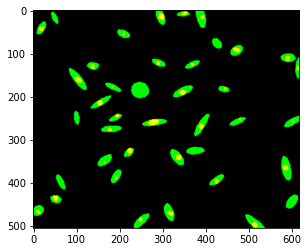

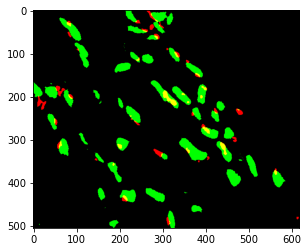

In [4]:
from matplotlib import pyplot
#rot[x_pos:x_pos+64, y_pos:y_pos+64, :, 0]
mask = imread('./Dataset/syntethic_mask_version2/Crop1.tif')
pyplot.imshow(mask[:, :, 31, :]/255.)

mask_ = imread('./Dataset/Masks/Crop1.tif')
pyplot.figure()
pyplot.imshow(mask_[:, :, 25, :]/255.)